# WordCloud and BubbleChart

## Installs

In [1]:
!pip install wordcloud
!pip install circlify
!pip install colour

## Imports

In [2]:
import os
import json
import circlify
import random
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from colour import Color
from wordcloud import WordCloud
from collections import defaultdict

## Constants

In [3]:
DATA_PATH = '../../src/data.js'
TRENDS_RAW_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/trends_raw.pkl"
TOPICS_PATH = "/mlodata1/prakhar/twitter_covid_insights/insights_All/topics.pkl"
TWEETS_PIPED_PATH = "/mlodata1/prakhar/all_available_tweets_piped"
DATES_INTERVAL = 1

## Word Clouds

### File load

In [4]:
with open(DATA_PATH) as f:
    f.seek(len('export default')) # ignore js syntax
    data = json.load(f) # load js data, now in json format

### Metatopic frequencies of hashtags

In [5]:
metatopic_hashtags_counter = {} # frequencies of hashtags in a metatopic

In [6]:
for metatopic in data:
    hashtags_counter = defaultdict(lambda: 0)
    for topic in metatopic['topics']:
        for hashtag in topic['hashtags']:
            hashtags_counter[hashtag['name']] += int(hashtag['count'])
    metatopic_hashtags_counter[metatopic['name']] = hashtags_counter

### WordCloud Builder

In [7]:
def make_wordcloud(frequencies_dict, title=None, mask=None, colormap=None, max_words=200):
    if not mask is None:
        mask = np.array(Image.open(mask))
    # Create Word Cloud
    wc = WordCloud(background_color='white', max_words=max_words, mask=mask,
                   colormap=colormap, contour_color='gainsboro', contour_width=1)
    wc.generate_from_frequencies(frequencies_dict)
    wc.to_file(f'../visualizations/plots2/{title}.png')
    # Plot Word Cloud
    plt.imshow(wc)
    plt.axis('off')
    if not title is None:
        plt.title(f'Metatopic: {title}')
    plt.show()

In [8]:
colormaps = [
            'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10',
            ]

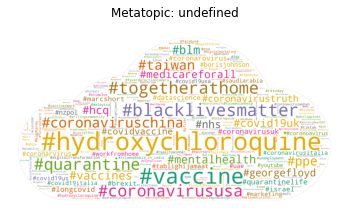

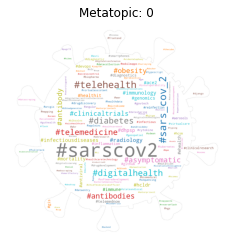

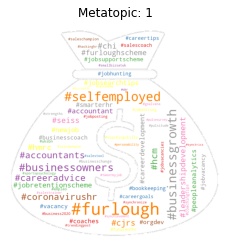

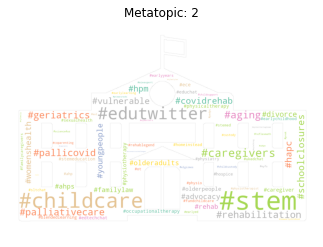

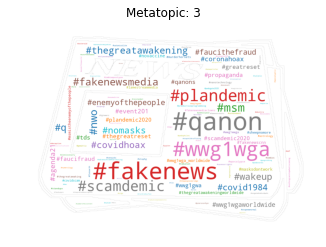

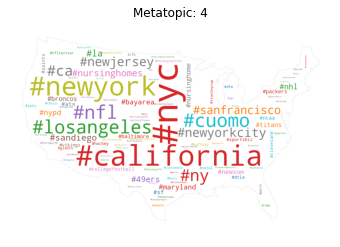

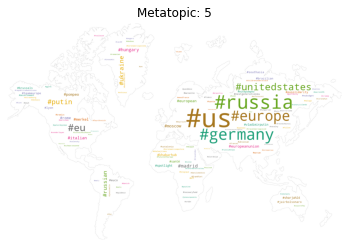

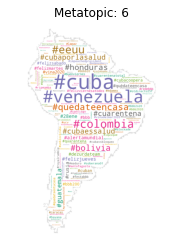

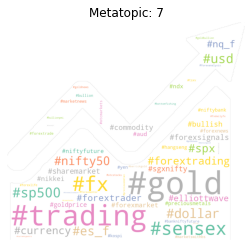

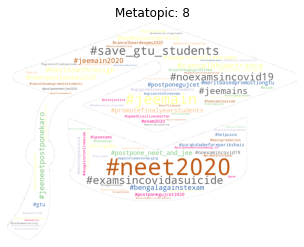

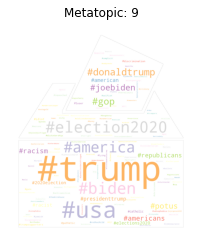

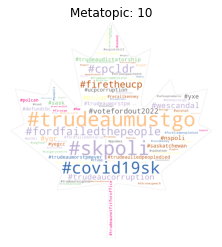

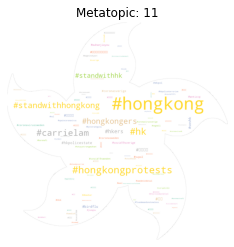

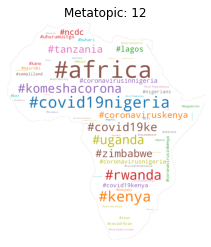

In [9]:
# generate Word Cloud for every metatopic
for index, metatopic in enumerate(data):
    make_wordcloud(metatopic_hashtags_counter[metatopic['name']],
                   title=metatopic['name'], max_words=250,
                   colormap=random.choice(colormaps), mask=f"masks2/topic_{metatopic['name']}.png")

## Circle Chart

### File load

In [10]:
def get_dates():
    file_names = os.listdir(TWEETS_PIPED_PATH)
    return [name.replace('parsed_', '').replace('.parquet', '') for name in file_names]

In [11]:
with open(TRENDS_RAW_PATH, 'rb') as f_trends_raw, open(TOPICS_PATH, 'rb') as f_topics:
    trends_raw = pkl.load(f_trends_raw)[0]
    trends_raw = {k: v for k, v in trends_raw.items() if not k.startswith('Pos') and not k.startswith('Neg')}
    topics = pkl.load(f_topics)[0]
    topic_labels = {k: v[0] for k, v in topics.items()}
    dates = get_dates()

### Events' counts

In [12]:
def get_event_counts(event_date, n=10):
    try:
        d_i = dates.index(event_date) # may throw if an invalid date
        l_i = max(0, d_i - DATES_INTERVAL)
        r_i = min(len(dates), d_i + DATES_INTERVAL + 1)
        # compute the sum of the trends over the interval
        interval_counts = {topic: sum(trends_raw[str(topic)][l_i:r_i]) for topic in topics}
        # sort the topics by their count
        interval_counts = dict(sorted(interval_counts.items(), key=lambda item: item[1], reverse=True))
        # keep top n
        interval_counts = {topic_labels[k]: interval_counts[k] for k in list(interval_counts)[:n]}
        return interval_counts
    except ValueError:
        return None

In [26]:
events = {'Pfizer US Emergency authorization': '2020-12-11',
         'Cases Peak': '2021-01-08'}
# DO NOT USE 'purple'
events_colors = {'Pfizer US Emergency authorization': (Color("#e03010"), Color("#f29a8a")),
                 'Cases Peak': (Color("#196fe0"), Color("#79a9e8")),
                 'Cases Peak2': (Color("#196fe0"), Color("#79a9e8"))}
events_counts = {}
for event, event_date in events.items():
    events_counts[event] = get_event_counts(event_date)

### CircleChart builder

In [27]:
def make_circlechart(data, colors, ax, title=None):
    labels, values = zip(*data)
    circles = circlify.circlify(values, show_enclosure=False,
                                target_enclosure=circlify.Circle(x=0, y=0, r=1))
    # Title
    if not title is None:
        ax.set_title(title, fontsize=40)
    # Remove axes
    ax.axis('off')
    # Find axis boundaries
    lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r) for circle in circles)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    # print circles
    for circle, label, color in zip(circles, labels, colors):
        x, y, r = circle
        ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color))
        ax.annotate(label, (x, y), va='center', ha='center', fontsize=150*r)

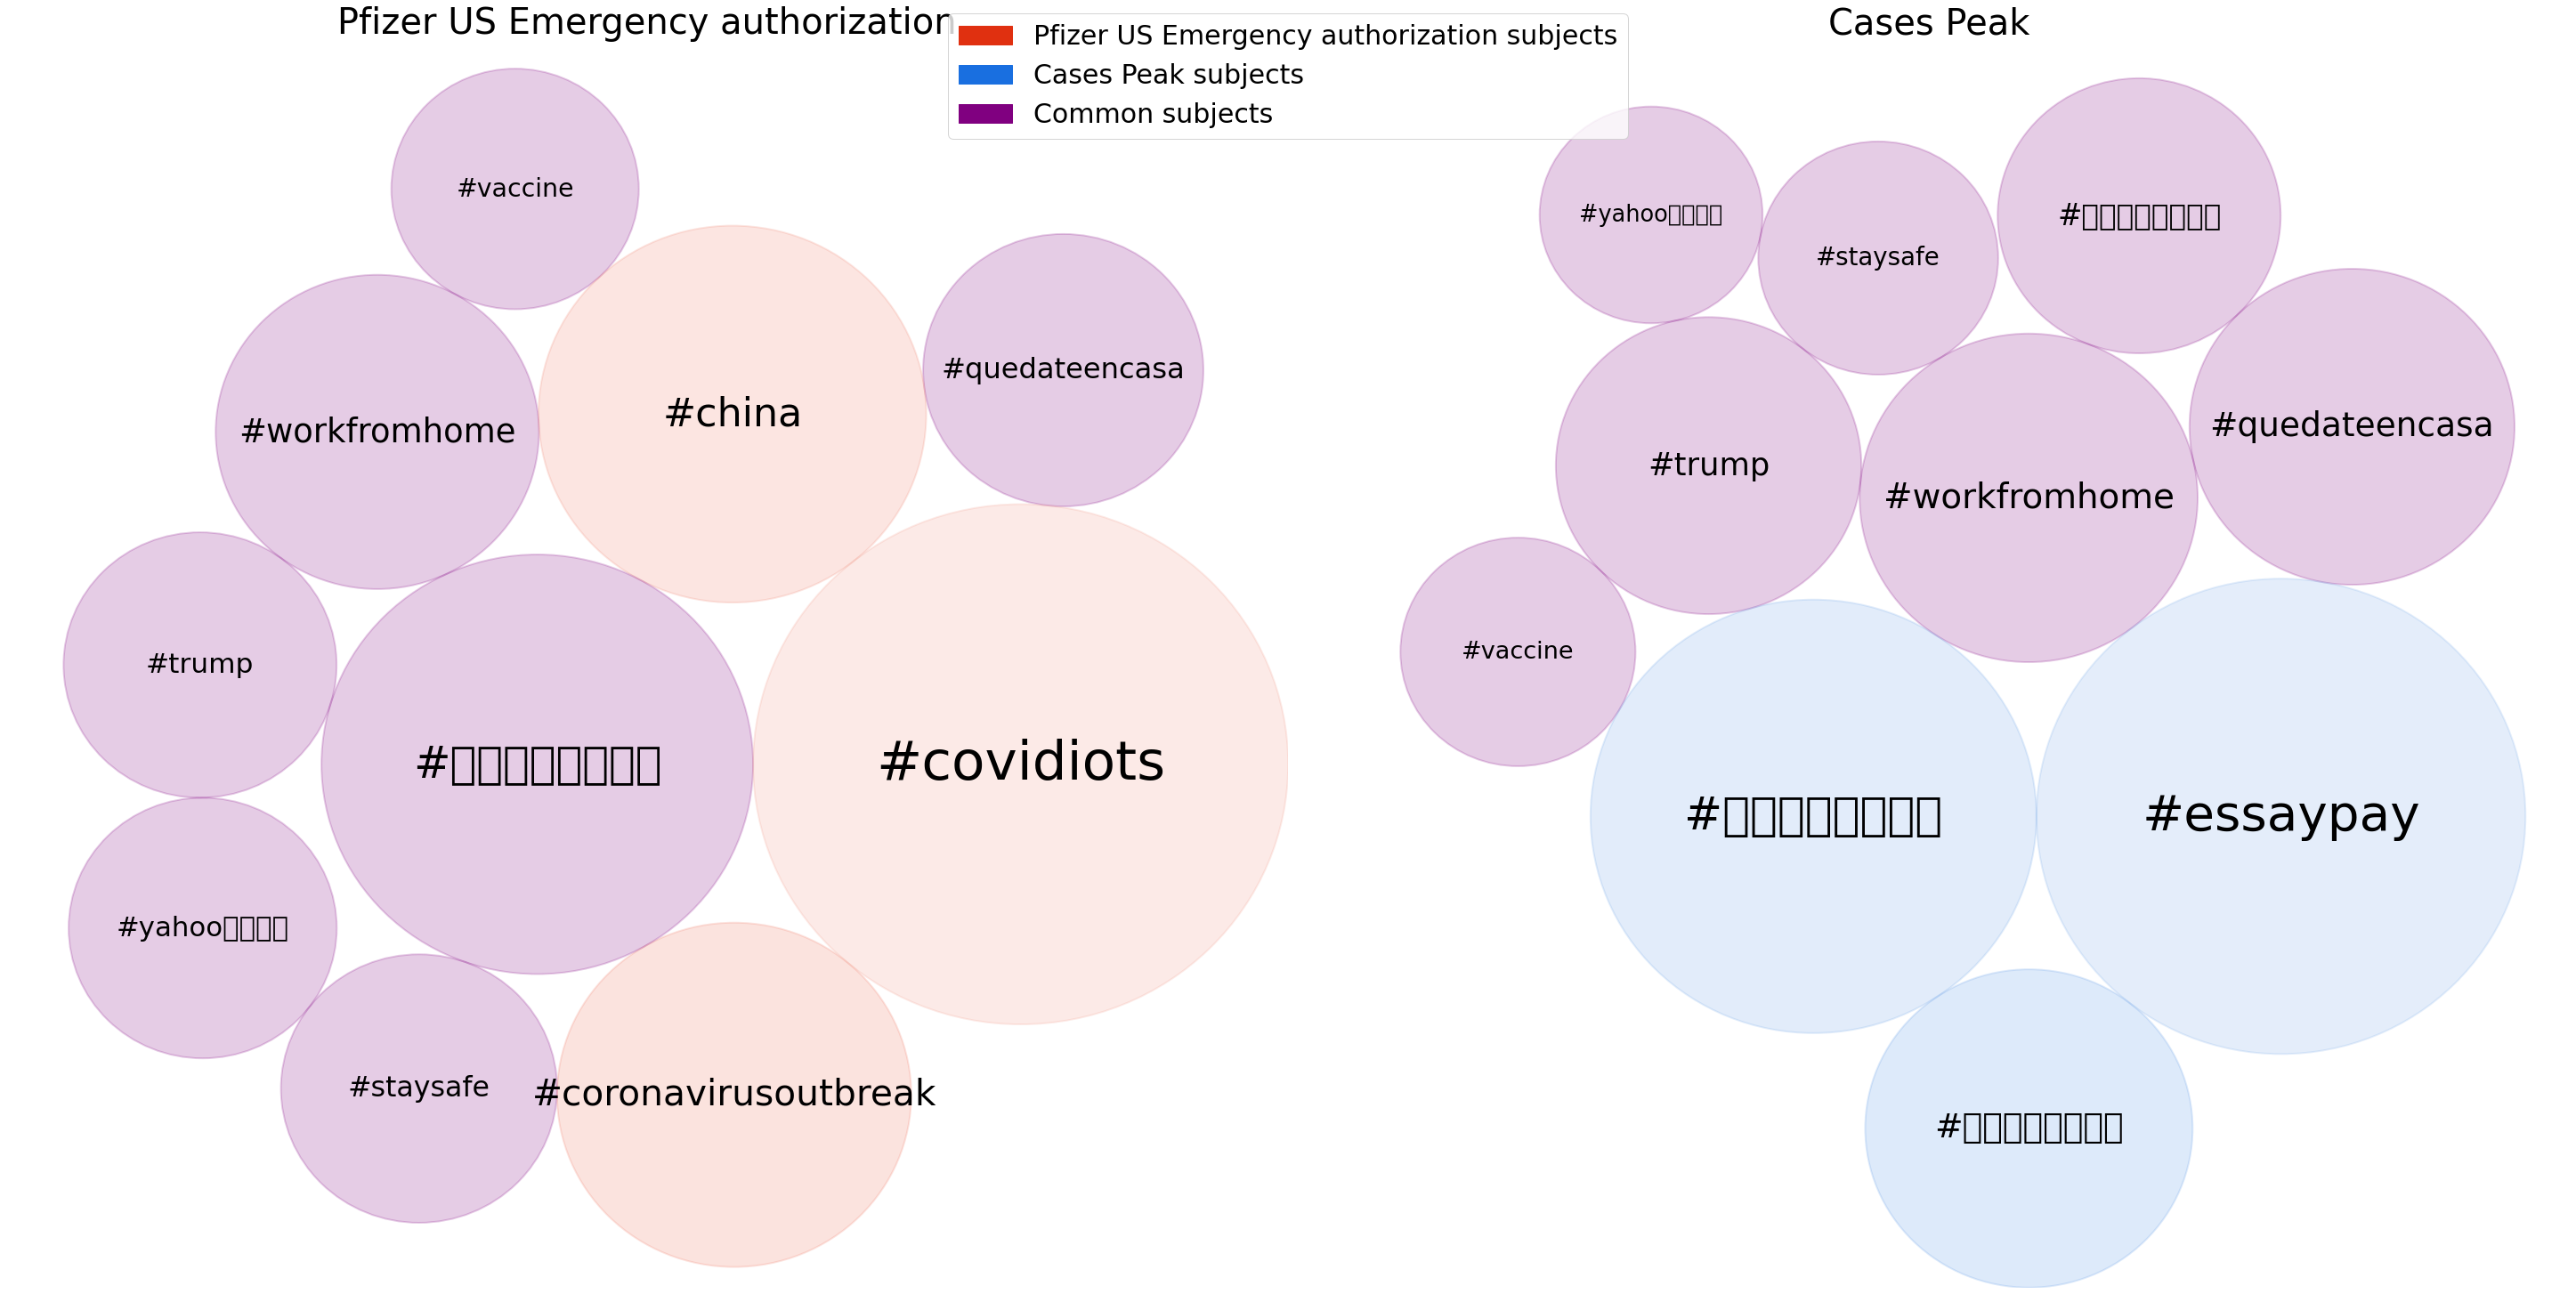

In [28]:
fig, ax = plt.subplots(1, len(events_counts), figsize=(40, 20))
handles = []
labels = [event_counts.keys() for (_, event_counts) in events_counts.items()]
common_labels = set.intersection(*map(set, labels))
for i, (event, event_counts) in enumerate(events_counts.items()):
    # Generate colors for circles
    c_start, c_end = events_colors[event]
    colors = map(lambda c: c.hex_l, c_start.range_to(c_end, len(event_counts)))
    colors = list(colors)
    # Create legend for circles
    handle = mpatches.Patch(color=colors[0], label=f'{event} subjects')
    handles.append(handle)
    # Set common labels color to purple
    labels = list(event_counts.keys())
    color_mapper = lambda e: 'purple' if labels[e[0]] in common_labels else e[1]
    colors = np.array(list(map(color_mapper, enumerate(colors))))
    # Plot circles
    make_circlechart(event_counts.items(), colors, ax[i], title=event)
handle = mpatches.Patch(color='purple', label=f'Common subjects')
handles.append(handle)
fig.legend(handles=handles, fontsize=30, loc='upper center')
plt.tight_layout(pad=0)